# **Sentiment Analysis of Book reviews from Amazon Kindle Store category Using Deep Learning**

### This dataset is a small subset of the unprocessed dataset of Amazon Kindle Reviews and it is obtained from Amazon product data, Julian McAuley, UCSD website. http://jmcauley.ucsd.edu/data/amazon/is. The dataset contains 12000 rows of review text and its corresponding metadata.
### The dataset has 11 features/columns, which are:
#### -asin           - ID of the product, like B000FA64PK
#### -helpful        - helpfulness rating of the review - example: 2/3.
#### -overall        - rating of the product.
#### -reviewText     - text of the review (heading).
#### -reviewTime     - time of the review (raw).
#### -reviewerID     - ID of the reviewer, like A3SPTOKDG7WBLN
#### -reviewerName   - name of the reviewer.
#### -summary        - summary of the review (description).
#### -unixReviewTime - unix timestamp.
#### Apart from these features, there are 2 more columns in this dataset, which are unnamed/insignificant.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense, Dropout, SpatialDropout1D
from tensorflow.keras.layers import Embedding

In [ ]:
data = pd.read_csv("all_kindle_review .csv")

In [ ]:
data.head()

,Unnamed: 0.1,Unnamed: 0,asin,helpful,rating,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,0,11539,B0033UV8HI,"[8, 10]",3,"Jace Rankin may be short, but he's nothing to ...","09 2, 2010",A3HHXRELK8BHQG,Ridley,Entertaining But Average,1.283386e+09
1,1,5957,B002HJV4DE,"[1, 1]",5,Great short read. I didn't want to put it dow...,"10 8, 2013",A2RGNZ0TRF578I,Holly Butler,Terrific menage scenes!,1.381190e+09
2,2,9146,B002ZG96I4,"[0, 0]",3,I'll start by saying this is the first of four...,"04 11, 2014",A3S0H2HV6U1I7F,Merissa,Snapdragon Alley,1.397174e+09
3,3,7038,B002QHWOEU,"[1, 3]",3,Aggie is Angela Lansbury who carries pocketboo...,"07 5, 2014",AC4OQW3GZ919J,Cleargrace,very light murder cozy,1.404518e+09
4,4,1776,B001A06VJ8,"[0, 1]",4,I did not expect this type of book to be in li...,"12 31, 2012",A3C9V987IQHOQD,Rjostler,Book,1.356912e+09


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2990 entries, 0 to 2989
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0.1    2990 non-null   int64  
 1   Unnamed: 0      2990 non-null   int64  
 2   asin            2990 non-null   object 
 3   helpful         2990 non-null   object 
 4   rating          2990 non-null   int64  
 5   reviewText      2990 non-null   object 
 6   reviewTime      2989 non-null   object 
 7   reviewerID      2989 non-null   object 
 8   reviewerName    2980 non-null   object 
 9   summary         2989 non-null   object 
 10  unixReviewTime  2989 non-null   float64
dtypes: float64(1), int64(3), object(7)
memory usage: 257.1+ KB


## **Data Cleaning**

In [ ]:
data.drop(['Unnamed: 0', 'Unnamed: 0.1','asin','helpful','reviewTime','reviewerID','reviewerName','summary','unixReviewTime'], axis = 1, inplace = True)

### For performing sentiment analysis, we mainly need the 'rating' and the 'reviewText' column. Thus, we are dropping all the other columns from our dataset over here.

In [ ]:
data.head()

,rating,reviewText
0,3,"Jace Rankin may be short, but he's nothing to ..."
1,5,Great short read. I didn't want to put it dow...
2,3,I'll start by saying this is the first of four...
3,3,Aggie is Angela Lansbury who carries pocketboo...
4,4,I did not expect this type of book to be in li...


In [ ]:
data.rating.value_counts()

4    782
5    753
1    506
3    477
2    472
Name: rating, dtype: int64

In [ ]:
data.rating=data.rating.replace([1,2],0)
data.rating=data.rating.replace([3],1)
data.rating=data.rating.replace([4,5],2)

### Here, we are converting all the ratings of values 1,2 to Negative Review(Denoted as 0) , 3 to Neutral Review(Denoted as 1) and 4,5 to Positive Review(Denoted as 2)

In [ ]:
data.rating.value_counts()

2    1535
0     978
1     477
Name: rating, dtype: int64

<Axes: xlabel='rating', ylabel='count'>

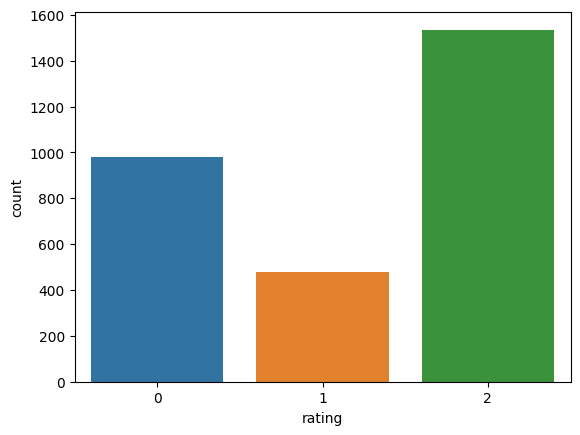

In [ ]:
sns.countplot(x=data["rating"])

In [ ]:
data

,rating,reviewText
0,1,"Jace Rankin may be short, but he's nothing to ..."
1,2,Great short read. I didn't want to put it dow...
2,1,I'll start by saying this is the first of four...
3,1,Aggie is Angela Lansbury who carries pocketboo...
4,2,I did not expect this type of book to be in li...
...,...,...
2985,2,4.5 FeathersWolf FlightReviewed by Francesca a...
2986,2,I liked that this book had a few new ideas com...
2987,2,I ABSOLUTELY LOVED THIS STORY!!! The author di...
2988,0,This is nothing but smut. I realize that eroti...


# Preprocessing

In [ ]:
from nltk.corpus import stopwords
import string
import nltk
import re
import gensim
from nltk.tokenize.treebank import TreebankWordDetokenizer

In [ ]:
def depure_data(data):

    #Removing URLs with a regular expression
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    data = url_pattern.sub(r'', data)

    # Remove Email
    data = re.sub('\S*@\S*\s?', '', data)

    # Remove new line characters
    data = re.sub('\s+', ' ', data)

    # Remove distracting single quotes
    data = re.sub("\'", "", data)

    # Removing punctuation
    exclude = set(string.punctuation)
    try:
        data = ''.join(ch for ch in data if ch not in exclude)
    except:
        pass

    return data

### Here, we have defined a function to remove the unnecessary punctuations, URL indicators such as 'https', 'www', etc., email address indicators like '@' and other characters like single quotes and new line characters from our reviewText sentences

In [ ]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

### Here, we have defined another function using gensim.utils.simple_preprocess() function to tokenize the reviews, but apart from tokenizing it is also converting all the characters in the reviews to lower case characters, removing the tokens containing only 2 characters and it also removing the accent marks from letters such that letters like 'é' will be converted to 'e'.

In [ ]:
def detokenize(text):
    return TreebankWordDetokenizer().detokenize(text)

### Here, we have defined another function to convert the tokens previously formed to sentences using detokenize() function before tokenizing it again into sequence of integers

In [ ]:
temp = []
#Splitting pd.Series to list
data_to_list = data['reviewText'].values.tolist()
for i in range(len(data_to_list)):
    temp.append(depure_data(data_to_list[i]))
data_words = list(sent_to_words(temp))
input = []
for i in range(len(data_words)):
    input.append(detokenize(data_words[i]))
print(input[:5])

['jace rankin may be short but hes nothing to mess with as the man who was just hauled out of the saloon by the undertaker knows now hes famous bounty hunter in oregon in the who when he shot the man in the saloon just finished years long quest to avenge his sisters murder and is now trying to figure out what to do next when the snottynosed farm boy he just rescued from gang of bullies offers him money to kill man who forced him off his ranch he reluctantly agrees to bring the man to justice but not to kill him outright but first he needs to tell his sisters widower the newskyla kyle springer bailey has been riding the trails and sleeping on the ground for the past month while trying to find jace she wants revenge on the man who killed her husband and took her ranch amongst other crimes and shes not so keen on the detour jace wants to take but she realizes shes out of options so she hides behind her boy persona as best she can and tries to keep pace when confrontation along the way get

### Here, we have used all the functions previously defined for performing the necessary preprocessing steps on our dataset

In [ ]:
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras import regularizers

max_words = 10000
max_len = 200

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(input)
sequences = tokenizer.texts_to_sequences(input)
tweets = pad_sequences(sequences, maxlen=max_len)
print(tweets)

[[ 129  152 1367 ...    8   93 1486]
 [   0    0    0 ...  107 2222  296]
 [   0    0    0 ... 1487   11 8963]
 ...
 [   0    0    0 ...    9    7   29]
 [   0    0    0 ...  401    4   71]
 [   0    0    0 ...    0    0    0]]


### After improving the quality of the reviews, we are finally going to tokenize the reviews into sequence of integers and then we are going to pad the sequences to length 200

In [ ]:
sentiment_label = pd.get_dummies(data['rating']).values
sentiment_label

array([[0, 1, 0],
       [0, 0, 1],
       [0, 1, 0],
       ...,
       [0, 0, 1],
       [1, 0, 0],
       [0, 0, 1]], dtype=uint8)

### Here, we are using Pandas get_dummies() function to perform one-hot encoding on the ratings

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(tweets, sentiment_label, test_size=0.33, random_state=42)

### Here, we are going to train our model using two-third, i.e., 66.67% of our dataset and then we are going to test our model with the help of the remaining one-third, i.e., 33.33% of our dataset

In [ ]:
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(2003, 200) (2003, 3)
(987, 200) (987, 3)


In [ ]:
from keras.models import Sequential
from keras import layers
from keras import regularizers
from keras import backend as K
from keras.callbacks import ModelCheckpoint
import tensorflow as tf

# **Model 1: LSTM Layers**

In [ ]:
model1 = Sequential()
model1.add(layers.Embedding(max_words ,128, input_length = X_train.shape[1])) #The embedding layer
#model1.add(SpatialDropout1D(0.25))
model1.add(layers.LSTM(50,dropout=0.5)) #,recurrent_dropout=0.5)) #Our LSTM layer
#model1.add(Dropout(0.2))
#model1.add(layers.Flatten())
model1.add(layers.Dense(3, activation='softmax'))
model1.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])

checkpoint1 = ModelCheckpoint("best_model1.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)

history1 = model1.fit(X_train, y_train,validation_data = (X_test , y_test),epochs=70, callbacks=[checkpoint1])


Epoch 1/70
63/63 [==============================] - ETA: 0s - loss: 0.9969 - accuracy: 0.5042
Epoch 1: val_accuracy improved from -inf to 0.61803, saving model to best_model1.hdf5
63/63 [==============================] - 20s 185ms/step - loss: 0.9969 - accuracy: 0.5042 - val_loss: 0.9288 - val_accuracy: 0.6180
Epoch 2/70
63/63 [==============================] - ETA: 0s - loss: 0.8234 - accuracy: 0.6640
Epoch 2: val_accuracy improved from 0.61803 to 0.66971, saving model to best_model1.hdf5
63/63 [==============================] - 9s 136ms/step - loss: 0.8234 - accuracy: 0.6640 - val_loss: 0.7970 - val_accuracy: 0.6697
Epoch 3/70
63/63 [==============================] - ETA: 0s - loss: 0.6624 - accuracy: 0.7269
Epoch 3: val_accuracy improved from 0.66971 to 0.70821, saving model to best_model1.hdf5
63/63 [==============================] - 9s 139ms/step - loss: 0.6624 - accuracy: 0.7269 - val_loss: 0.7195 - val_accuracy: 0.7082
Epoch 4/70
63/63 [==============================] - ETA: 0s 

In [ ]:
print(model1.summary())
pred1 = model1.predict(X_test)
y_pred1 = np.argmax(pred1, axis=1)
Y_test = np.argmax(y_test, axis=1)

from sklearn.metrics import classification_report
print(classification_report(Y_test, y_pred1))


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 128)          1280000   
                                                                 
 lstm (LSTM)                 (None, 50)                35800     
                                                                 
 dense (Dense)               (None, 3)                 153       
                                                                 
Total params: 1,315,953
Trainable params: 1,315,953
Non-trainable params: 0
_________________________________________________________________
None
31/31 [==============================] - 1s 6ms/step
              precision    recall  f1-score   support

           0       0.65      0.79      0.71       319
           1       0.29      0.22      0.25       140
           2       0.79      0.74      0.76       528

    accuracy                      

# **Model 2 : Bidirectional LSTM Layers**

In [ ]:
#importing necessary libraries for medelling

from keras.models import Sequential
from keras import layers
from keras.layers import Embedding
from keras import regularizers
from keras import backend as K
from keras.callbacks import ModelCheckpoint
import tensorflow as tf

### Here, we are going to fit Bidirectional LSTM model to our dataset as it is capable of using bidirectional propagation mechanism for capturing both historical and future data, which helps us to get better results compared to LSTM as LSTM is unable to capture future data.

In [ ]:
model = Sequential()
model.add(layers.Embedding(max_words, 40, input_length=max_len))
model.add(layers.Bidirectional(layers.LSTM(20,dropout=0.6)))
model.add(layers.Dense(3,activation='softmax'))
model.compile(optimizer='rmsprop',loss='binary_crossentropy', metrics=['accuracy'])
checkpoint = ModelCheckpoint("best_model.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history = model.fit(X_train, y_train, epochs=70,validation_data=(X_test, y_test),callbacks=[checkpoint])

Epoch 1/70
252/252 [==============================] - ETA: 0s - loss: 0.5855 - accuracy: 0.5290
Epoch 1: val_accuracy improved from -inf to 0.66566, saving model to best_model.hdf5
252/252 [==============================] - 31s 110ms/step - loss: 0.5855 - accuracy: 0.5290 - val_loss: 0.5164 - val_accuracy: 0.6657
Epoch 2/70
252/252 [==============================] - ETA: 0s - loss: 0.4737 - accuracy: 0.6771
Epoch 2: val_accuracy improved from 0.66566 to 0.70707, saving model to best_model.hdf5
252/252 [==============================] - 18s 70ms/step - loss: 0.4737 - accuracy: 0.6771 - val_loss: 0.4395 - val_accuracy: 0.7071
Epoch 3/70
252/252 [==============================] - ETA: 0s - loss: 0.4213 - accuracy: 0.7215
Epoch 3: val_accuracy improved from 0.70707 to 0.73056, saving model to best_model.hdf5
252/252 [==============================] - 15s 61ms/step - loss: 0.4213 - accuracy: 0.7215 - val_loss: 0.4151 - val_accuracy: 0.7306
Epoch 4/70
252/252 [==============================]

In [ ]:
print(model.summary())
pred = model.predict(X_test)
y_pred = np.argmax(pred, axis=1)
Y_test = np.argmax(y_test, axis=1)

from sklearn.metrics import classification_report
print(classification_report(Y_test, y_pred))

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 200, 40)           400000    
                                                                 
 bidirectional_3 (Bidirectio  (None, 40)               9760      
 nal)                                                            
                                                                 
 dense_3 (Dense)             (None, 3)                 123       
                                                                 
Total params: 409,883
Trainable params: 409,883
Non-trainable params: 0
_________________________________________________________________
None
124/124 [==============================] - 2s 9ms/step
              precision    recall  f1-score   support

           0       0.76      0.75      0.76      1358
           1       0.36      0.24      0.29       634
           2       0.78

### Here, we achieved an accuracy of 73% after fitting the Bidirectional LSTM model to our dataset. But, as our dataset is unbalanced, so we are mainly going to focus on the weighted averages of precision, recall and f1-score, which are 71%, 73% and 71% respectively. Hence, we can conclude that our model is performing quite well.

##Curves representing training and Validation loss and training and Validation accuracy for the LSTM model

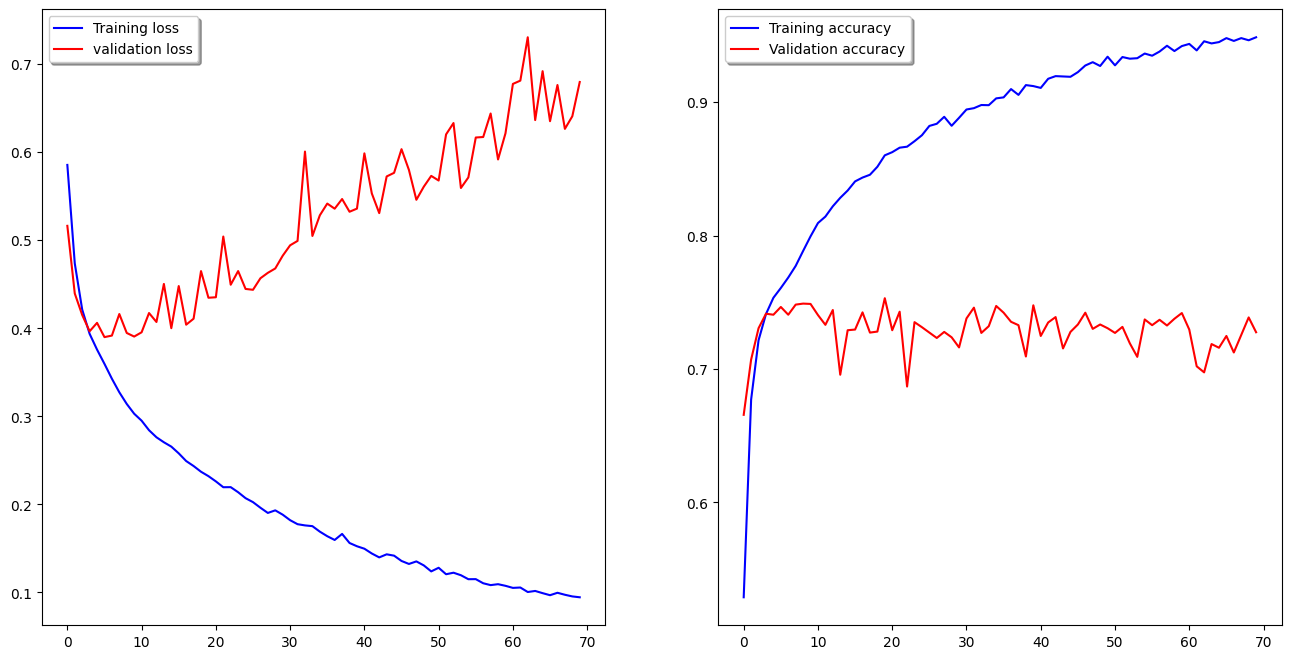

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,2, figsize=(16,8))
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

### Here, we can observe that the train loss is decreasing and the train accuracy is increasing with an increase in the number of epoches, which is certainly favourable. However, at the same time, we can also observe that the validation accuracy is fluctuating, but mainly remaining constant and validation loss is increasing, instead of decreasing with an increase in the number of epoches. This may explain the model's inability to achieve even better performance.

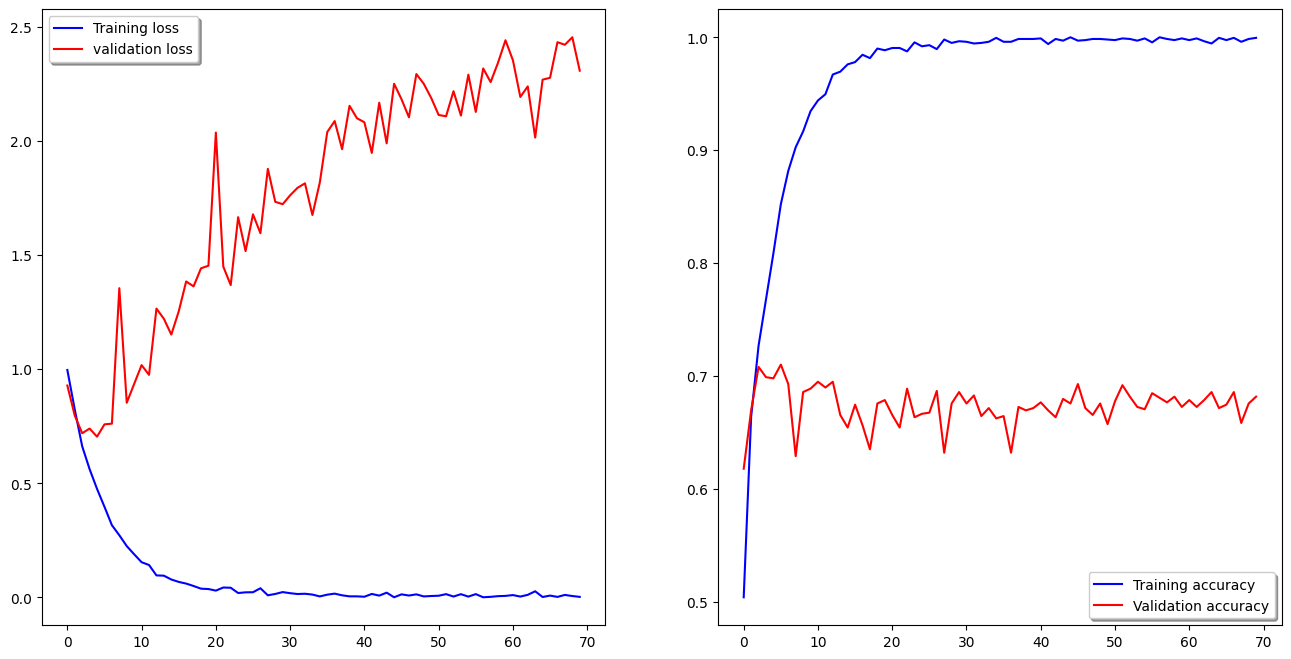

In [ ]:
#LSTM

import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,2, figsize=(16,8))
ax[0].plot(history1.history['loss'], color='b', label="Training loss")
ax[0].plot(history1.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history1.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history1.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)